# Ejercicio de Feedback Regresiones y Random Forest

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow_datasets

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import roc_curve, auc

## Regresión lineal

Consideramos el siguiente dataframe

In [4]:
from ucimlrepo import fetch_ucirepo

auto_mpg = fetch_ucirepo(id=9)

X = auto_mpg.data.features
Y = auto_mpg.data.targets

df=pd.concat([X,Y],axis=1)

Con las siguientes columnas:

**displacement**: Volumen de la cilindrada total del motor.

**cylinders**: Número de cilindros del motor del automóvil.

**horsepower**: Potencia en caballos del motor del automóvil.

**weight**: Peso del automóvil.

**acceleration**: Tiempo de aceleración de 0km/h a 100km/h en segundos

**model_year**: Año de fabricación del automóvil.

**origin**: Lugar de origen del automóvil, representado por un código numérico que indica el país de origen.

**mpg**: Millas por galón (MPG) que el automóvil puede recorrer.

## Regresión Logística

Consideramos el siguiente dataframe:

In [5]:
df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

valor_casa = df.median_house_value
valor      = 180000

df['affordability']=np.where(valor_casa>valor,0,1)
df = df.drop('median_house_value',axis=1)

Con las siguientes variables:

**longitude**: La longitud geográfica de la ubicación de la vivienda.

**latitude**: La latitud geográfica de la ubicación de la vivienda.

**housing_median_age**: La mediana de la edad de las viviendas en la zona. Puede representar cuánto tiempo han estado en pie las viviendas en esa área.

**total_rooms**: El número total de habitaciones en las viviendas de esa área.

**total_bedrooms**: El número total de dormitorios en las viviendas de esa área.

**population**: La población total en esa área.

**households**: El número total de hogares en esa área.

**median_income**: La mediana del ingreso familiar anual en esa área.

**affordability**: Capacidad de hacer frente a la compra de la casa atendiendo a su valor

## Árbol de decisión y Random Forest

Usando el siguiente dataset

In [6]:
from ucimlrepo import fetch_ucirepo

data = fetch_ucirepo(id=45)
X = data.data.features[['chol' ]]
Y = data.data.targets


Predecir el resultado de los valores de la variable chol de 180, 200, 250 y 290 con valores de max_depth diferentes y explicar las diferencias de predicción.

## Ejercicio de Deep Learning

Para este apartado usaremos el de Oxford-flowers-102


e:\CNN_Sports_Classifier\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


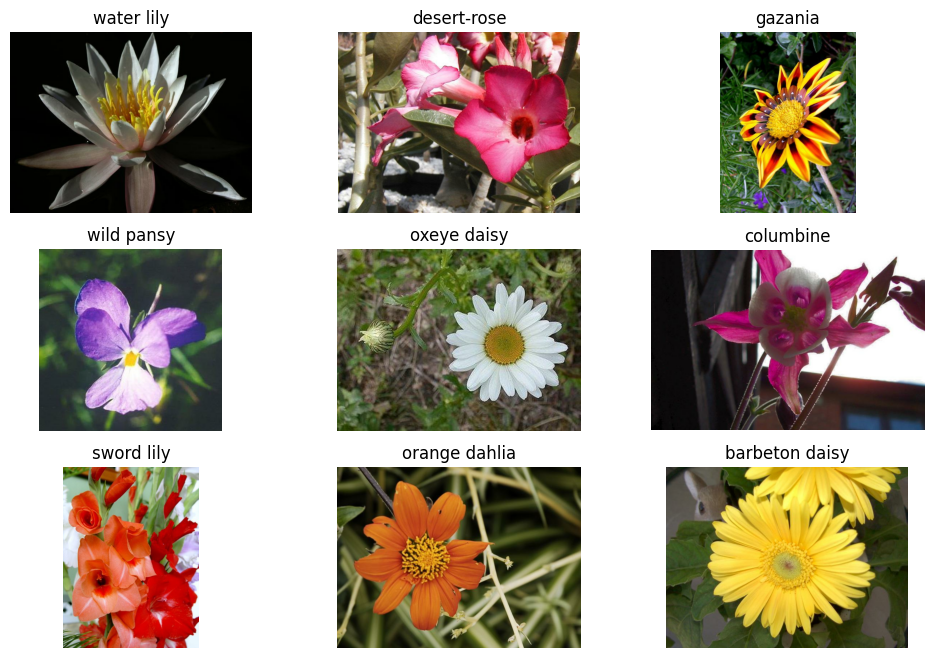

In [7]:
# load the dataset
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# create the train-test-validation datasets
train_dataset, test_dataset, validation_dataset = dataset['train'], dataset['test'], dataset['validation']

# take a look to the dataset
get_label_name = info.features['label'].int2str

plt.figure(figsize=(12,8))
for i, (image, label) in enumerate(train_dataset.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis('off')
plt.show()


Dado que en este dataset los  colores son importantes, procederemos a aplicar un preprocesamiento, pero sin modifcar la escala a gris.


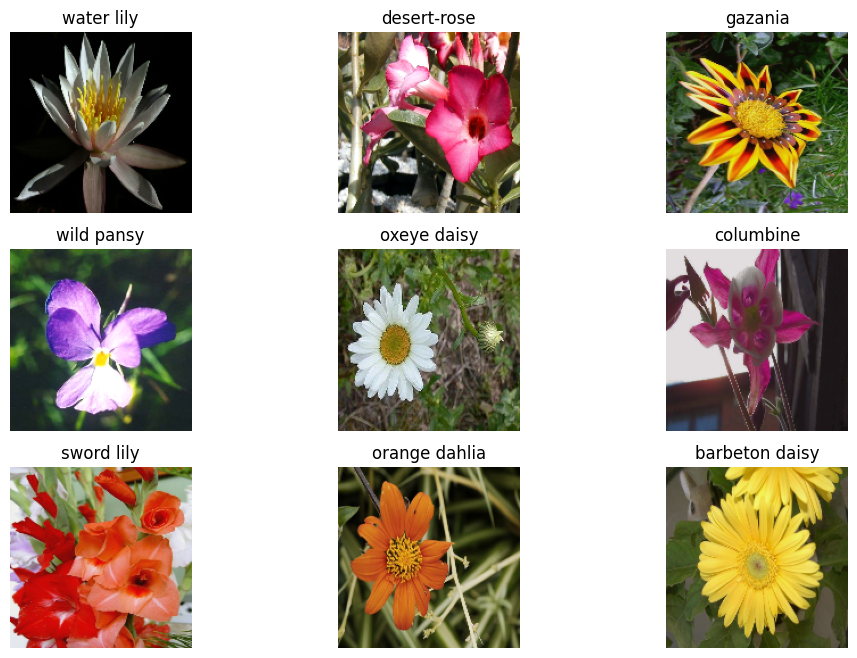

In [8]:
# due to the images had different sizes, we are going to keep them all in 120x120
size_image = [160,160]

def image_transformation_train(img, label):
  # resize the image
  img = tf.image.resize(img, size_image)
  # normalize
  img = tf.image.random_flip_left_right(img) 
  img = tf.image.random_brightness(img, max_delta=0.2)
  img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
  img = tf.cast(img, tf.float32) / 255.0
  return img, label

def image_transformation_test(img, label):
  # resize the image
  img = tf.image.resize(img, size_image)
  # normalize
  img = tf.cast(img, tf.float32) / 255.0
  return img, label
batch_size = 32
train_dataset = train_dataset.map(image_transformation_train)
test_dataset = test_dataset.map(image_transformation_test)
validation_dataset = validation_dataset.map(image_transformation_test)

plt.figure(figsize=(12,8))
for i, (img, label) in enumerate(train_dataset.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(get_label_name(label))
    plt.axis('off')
plt.show()

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

Como podemos observar ahora todas las imagenes tienen el mismo tamaño, y en color.

In [17]:
from re import L
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2

def create_model(num_clases, num_dense=120, activ_conv='relu',
                 activ_dense='softmax', padding='valid', l2_value=0.01):
  return models.Sequential([
    layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(160, 160, 3 ), kernel_regularizer=tf.keras.regularizers.l1(l2_value)),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.Activation(activ_conv),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding=padding),
    layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_regularizer=tf.keras.regularizers.l2(l2_value)),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.Activation(activ_conv),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding=padding),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(102, activation='softmax')  # 102 clases en el conjunto de datos Oxford Flowers 102
])

In [18]:
from sklearn.model_selection import learning_curve
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam

#model_1 = create_model(120, num_dense=200, activ_conv='relu',
#                 activ_dense='relu', padding='same')
file_path = 'best_model_1.keras'
#if os.path.isfile(file_path):
#    print("Cargando modelo")
#    model_1 = tf.keras.models.load_model(file_path)
#else:
print("Creando modelo")
model_1 = create_model(102, num_dense=512, activ_conv='relu',
                        activ_dense='softmax', padding='same', l2_value=0.0001)
print(model_1.summary())
## optimizer, usamos descendiente del gradiente
# al aumentar o disminuir momentum dependeremos mas o menos de los gradientes
# calculados anteriormente para el proximo salto (actualizacion de pesos)
#optimizer_a = SGD(learning_rate=0.00001, momentum=0.9)
optimizer_a = Adam(learning_rate=0.001)
# ya use el AdmaW optimizer, pero me funciona peor para este caso que SGD

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    verbose=1,
    min_lr=0.00000001
)

model_1.compile(
    optimizer=optimizer_a,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_1 = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max' )

## Entrenar los modelos, se guarda el mejor resultado hasta el momento
num_epochs = 100
history_1 = model_1.fit(train_dataset, epochs=num_epochs, batch_size=batch_size,
                        verbose=1, validation_data=(test_dataset),
                        callbacks=[checkpoint_1, early_stopping, reduce_lr])

Creando modelo
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 158, 158, 128)     3584      
                                                                 
 batch_normalization_3 (Batc  (None, 158, 158, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 158, 158, 128)     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 156, 156, 128)     147584    
                                                                 
 batch_normalization_4 (Batc  (None, 156, 156, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 156

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_4/dense_12/MatMul/MatMul_1' defined at (most recent call last):
    File "C:\Users\carlo\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\carlo\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\carlo\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\carlo\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\carlo\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\carlo\AppData\Local\Temp\ipykernel_24672\174422701.py", line 48, in <module>
      history_1 = model_1.fit(train_dataset, epochs=num_epochs, batch_size=batch_size,
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "e:\CNN_Sports_Classifier\.venv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_4/dense_12/MatMul/MatMul_1'
OOM when allocating tensor with shape[3115008,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_4/dense_12/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_41133]